### MRI BRAIN TUMOR SEGMENTATION CLASSIFIER
#### Author: Jacob Heyman
***


## Overview
11,700 people are diagnosed with brain tumors every year. Early and accurate detection is a big factor in increasing the life expectancy of the patients diagnosed with the tumors. Diagnosing brain tumors requires extensive imaging and expert visual analysis by highly trained individuals. Often times a neurosurgeon is needed to work alongside the radiologist to properly identify the tumors and classify the tumor type, such as pituitary, glioma or menigioma. Due to the large amount of imaging data produce, a Machine Learning algorithm can be used to classify the images with high accuracy. A properly trained model could help reduce human error in tumor identification and act as a preliminary tumor diagnosis. The classification model could also be used to improve the quality of analysis in underprivliged or emerging countries that do not have the same access to the higher standards of medicine.  

In this study I attempt to create a MRI tumor segmentation classifer that classifies images by the type of tumor.  Using a kaggle dataset of tumor MRI images, I created several convoluted nueral networks (CNN) to train a model on the key features of each tumor class.  My goal of the project is to reduce as many false negative classifications as possible in order for the model to act as a preliminary diagnosis tool. 

### Business Problem
MRI imaging is an essential step in diagnosing and categroizing types of tumors in patients.  Too image brain tumors with an MRI, hundreds of images are produced for an individual patient.  These images need expert analysis from a radiologist and a neurologist to identify and determine the type of tumor.  This process is time consuming and relies on the access to the high calibur doctors. To expediate diagnosis and broaden the accesability of accurate classification, a properly trained CNN can be used to classify different types of tumors and act as a preliminary diagnosostic tool.  In this study I plan to answer the following questions:
 
 1. Can a CNN classify tumors into four classes (glioma tumors, menigioma tumors, pituitary tumors and no tumors)
 2. What CNN architecture reduces the highest amount of false negatives/ has the highest recall
 3. What are the key features of each tumor class that is identified by the classification CNN


### Data Understanding
#### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, shutil
import numpy as np
from math import ceil
import itertools
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score
from skimage.feature import hog
from skimage import exposure
np.random.seed(123)

import keras
from keras import models
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.metrics import Recall, Precision 
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf

### Read in Image Data with datagenorator
The Images where obtained from a kaggle database [Brain_tumor_kaggle]('https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri')
The Images came in two folders, Train and Test and contained four classes of Brain tumor MRI images.  The tumor classes and there corresponding class number are:

- Glioma: 0
- Meningioma: 1
- No Tumor: 2
- Pituitary: 3
***
The images where read in using the keras ImageDataGenorator and resized to 224 by 224.  Using the next function, the images where seperated from their labels.  

In [2]:
directory = 'mri_data'
train_directory = 'mri_data/Training'
test_directory = 'mri_data/Testing'

In [3]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 2870, 
        seed = 123)

# separate images from labels
train_images, train_labels = next(data_train)
print('Found Classes: ',data_train.class_indices)

Found 2870 images belonging to 4 classes.
Found Classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


### Check distribution of Classes
To check for class imbalance, I plotted the sum of each class label.  There are significantly less images belonging to the no tumor class compared to the three other tumor classes.

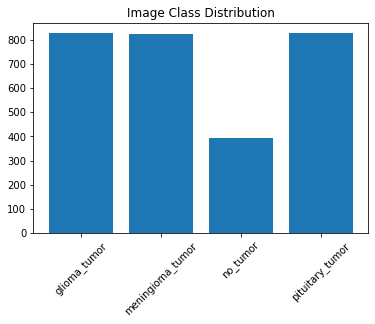

In [4]:
plt.bar(['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor'], sum(train_labels))
plt.xticks(rotation=45)
plt.title('Image Class Distribution');
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('./images/class_balance.png')

### Display assortment of different classes
For my next step I created a nine by nine plot to show a variety of the different tumor classes. The images appear to be several differnt MRI planes, including coronal, mid-sagittal and transverse.  The different planes of the MRI images makes it difficult to identify average features among each class, but will be advantageous for training a model to identify tumors for each class from multiple types of MRI images.  

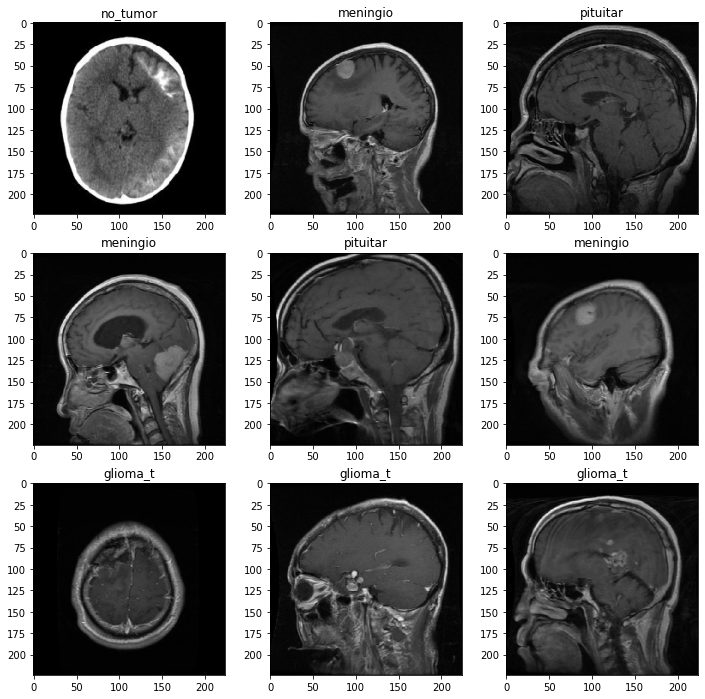

In [5]:
def get_label(array):
    """
    Returns String Label of Class
    """
    if array[0] ==1:
        return 'glioma_tumor'
    elif array[1] ==1:
        return 'meningioma_tumor'
    elif array[2] ==1:
        return 'no_tumor'
    elif array[3] ==1:
        return 'pituitary_tumor'

label_names = np.apply_along_axis(get_label,1,train_labels)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_images[i])
  plt.gca().set_title(label_names[i])
plt.show()

The images displayed above show how diverse the tumor classes are.  Where they not labled, a layman would most likely not be able to identify which images belonged to the specific tumor class.  

### Seperate images by class 
In this step I wanted to get a better look at each class of tumor.  Using the ImageDataGenerator I created image datasets for each class.  

In [6]:
#isolated milddemented class images 
data_glioma = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 717, 
        seed = 123,
        classes= ['glioma_tumor'])

data_meningioma = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 52, 
        seed = 123,
        classes= ['meningioma_tumor'])

data_no_tumor = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 2560, 
        seed = 123,
        classes= ['no_tumor'])

data_pituitary = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        train_directory, 
        target_size=(224, 224), 
        batch_size = 1792, 
        seed = 123,
        classes= ['pituitary_tumor'])

glioma_images, glioma_labels = next(data_glioma)
meningioma_images, meningioma_labels = next(data_meningioma)
no_tumor_images, no_tumor_labels = next(data_no_tumor)
pituitary_images, pituitary_labels = next(data_pituitary)

Found 826 images belonging to 1 classes.
Found 822 images belonging to 1 classes.
Found 395 images belonging to 1 classes.
Found 827 images belonging to 1 classes.


### Function for 9x9 image display by catagory
A function using the image 9x9 subplot to display the image data

In [7]:
def image_subplot(catagory,title):

    plt.figure(figsize=(12,12))

    for i in range(9):
      plt.subplot(330 + 1 + i)
      plt.imshow(catagory[i])
      plt.gca().set_title(title)
    return plt.show()

### Display images for each catagory
***
#### Glioma Tumors:

Glioma tumors, are tumors derived from cancer of the glial cells(non_neruonal cells), located in the central nervous system.  Key features of a glioma tumor in MRI images are a distinct asymetry in the structure of the brain.  Depending on the method of imageing, gliomas may be isointense (the same signal as the surrounding tissue) or hyperintense (brighter than the surrounding tissue). 

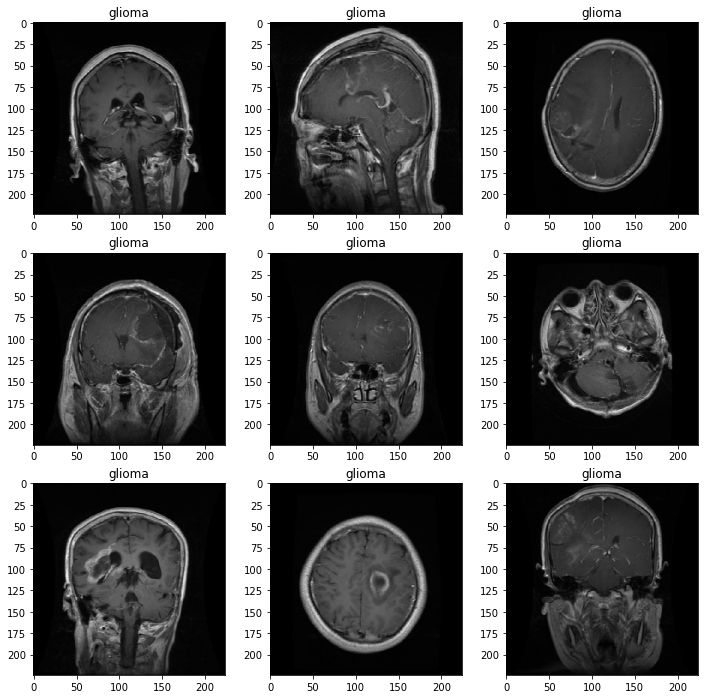

In [11]:
image_subplot(glioma_images,'glioma')

#### No tumors

Here are MRI images of healthy brains.  They are relativly symetrical and have uniform pixel intesnity for each feature.  

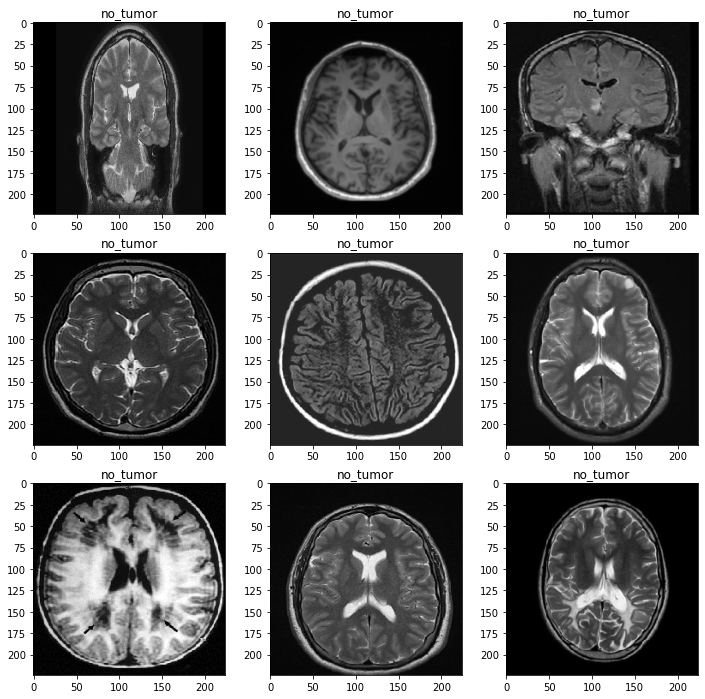

In [9]:
image_subplot(no_tumor_images,'no_tumor')

#### Menigioma Tumors

Menigiomas form from cancer in the meninges, the membrane around the brain and spinal chord.  Key features of a minigioma are hyperintese clusters of tissue that form inbewteen the brain and the skull.  In the images below some tumors appear to be more easily identifiable than others which might prove to be a challange for classification.  

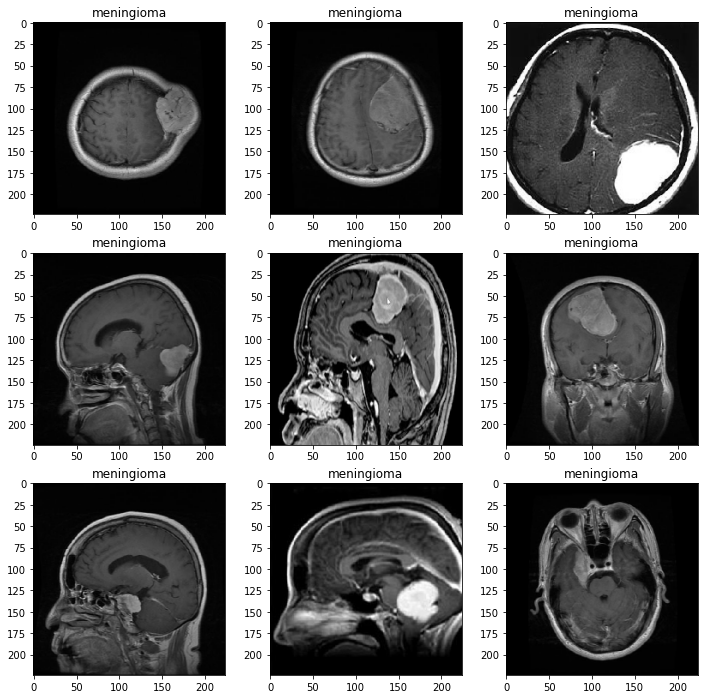

In [13]:
image_subplot(meningioma_images,'meningioma')

#### Pituitarty Tumors
Pituritary tumors are cancererous growths on the pituitary gland, located right below the hypothalamus.  Key features are a hyperintense cluster of pixels in the pituitary gland.  Several other structures surounding the pituitary gland are also hyperintense such as the orbital socket, which may act as a negative factor for classification.  

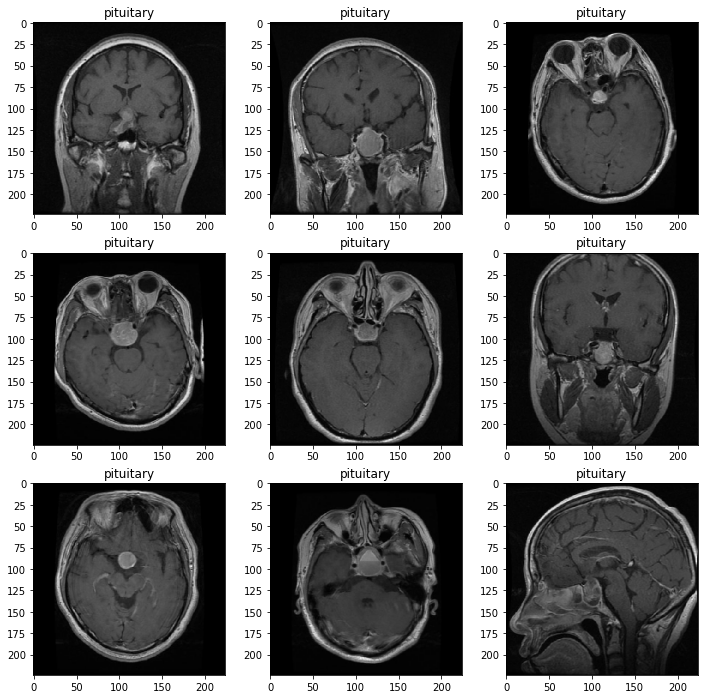

In [14]:
image_subplot(pituitary_images,'pituitary')

### Fixing Class Imbalance with image augmentation
Used imagedatagenorator to horizontil flip images and concatenate them into the train image dataset doubling the no tumor class

In [15]:
hflip = ImageDataGenerator(rescale=1./255,horizontal_flip=True)

no_tumor_aug = hflip.flow_from_directory(train_directory,
                                        target_size=(224,224),
                                        batch_size = 395,
                                        seed = 123,
                                        classes= ['no_tumor'])



no_tumor_images_aug, no_tumor_images_labels = next(no_tumor_aug)

Found 395 images belonging to 1 classes.


In [16]:
concat_notumor_images = np.vstack(no_tumor_images_aug)
concat_notumor_labels = np.array([[0.,0.,1.,0.] for i in range(len(no_tumor_images))])

train_images_aug = np.concatenate((train_images,no_tumor_images_aug))
train_labels_aug = np.concatenate((train_labels,concat_notumor_labels))

#### Class distribution after augmented data was added to no tumor class

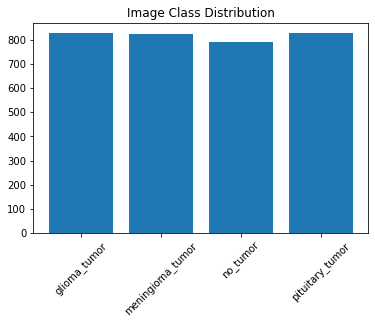

In [17]:
plt.bar(['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor'], sum(train_labels_aug))
plt.xticks(rotation=45)
plt.title('Image Class Distribution');
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('./images/class_balance.png')

### Using Image augmentation to brighten images
In my ititial modeling process found in [MRI modeling]('./MRI_Image_CNN's.ipynb'), I found no improvment with the the balanced dataset.  Since the hyperintensity of some tumors is a visual que for classification, I decided to created a dataset with a range of brightned images added to the original dataset.  I brightened the images on a range from no change to 60% increased brightness and added the augmented images to the original dataset doubling the amount of images.   

In [18]:
bright = ImageDataGenerator(rescale=1./255,brightness_range=(1.0,1.6))

train_bright = bright.flow_from_directory(train_directory,
                                        target_size=(224,224),
                                        batch_size = 2297,
                                        seed = 123,
                                        classes = ['no_tumor','glioma_tumor','meningioma_tumor','pituitary_tumor'])
train_bright_images, train_bright_labels = next(train_bright)



print('Found Classes: ',train_bright.class_indices)

Found 2870 images belonging to 4 classes.
Found Classes:  {'no_tumor': 0, 'glioma_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}


In [19]:
train_total_bright_images = np.concatenate((train_images,train_bright_images))
train_total_bright_labels = np.concatenate((train_labels,train_bright_labels))

### 9x9 Brightened MRI Images
The Images below show the range of different random levels of adjusted brightness up to 60% increased intensity. 

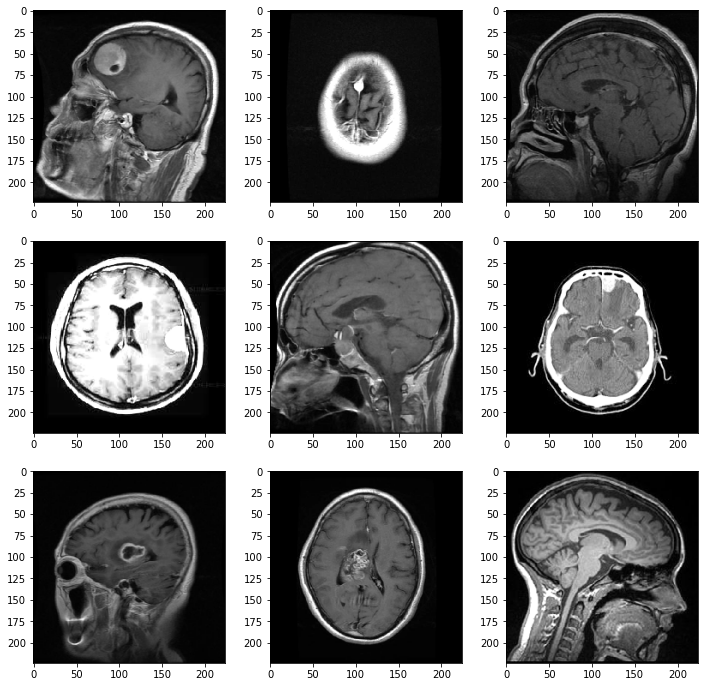

In [21]:
image_subplot(train_bright_images,'')


### Modeling Process
Link to the image classification modeling process
[MRI_Image_Classification](./MRI_Image_CNN's.ipynb)